In [6]:
#Importing libraries
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
import random
import shutil
from PIL import Image

x_dim = 32
y_dim = 32

In [67]:
#Splitting the dataset into train and test folders. Please create test and train dir in the given path before running this.

def delete_contents(folder): # function to delete the files in a dir
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def get_files_from_folder(path): #Returns all the files and folders in a given path.

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, path_to_train_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))
    train_counter = np.round(data_counter_per_class * train_ratio)

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])

        #creates dir
        # Kavya : better if checked outside the for loop
        if not os.path.exists(path_to_test_data):
            os.makedirs(path_to_test_data)
        if not os.path.exists(path_to_train_data):
            os.makedirs(path_to_train_data)
            
        files = get_files_from_folder(path_to_original)
        random.shuffle(files)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_test_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
        #files = get_files_from_folder(path_to_original)
        #random.shuffle(files)
        for j in range(int(test_counter[i]),len(files)):
            dst = os.path.join(path_to_train_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
if __name__ == "__main__":
    delete_contents('./train')
    delete_contents('./test')
    main('./Images_face96','./test','./train',0.7)

In [68]:
#Path for the training images

Path = './train/'
files = os.listdir(Path)
files.sort()

In [69]:
#Converting each image to Grayscale and appending the data to images

images = []

for name in files:
    temp = cv2.imread('./train/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (x_dim,y_dim), interpolation = cv2.INTER_AREA)
    images.append(temp.flatten())
        
# total number of images considered : 360 - 5 of each person
# images converted to grayscale of size : (100,100)

# images : rows - 360
#          columns - 100*100 = 10000
# images.shape : (360,10000)

# temp.shape : (100, 100)

In [70]:
# Calculating the mean of images

images = np.array(images)
image_mean = images.mean(axis = 0)
images = images - image_mean
images = images.T
# transpose of images taken to find eigen vectors of matrix A'A

# image_mean.shape : (100000,)
# images.shape : (10000, 360)

In [88]:
#Saving 4 sample difference faces
h = []
for i in random.sample(range(images.shape[1]),4):
    reshape = np.reshape(images[:,i], (32, 32))
    new_p = Image.fromarray(reshape) # unflattening the image
    new_p = new_p.convert("L") #convert to grayscale image.
    new_p = np.array(new_p) # making numpy array
    new_p= cv2.copyMakeBorder(new_p,3,3,3,3,cv2.BORDER_CONSTANT,value=[255,255,255]) #adding the padding to the images.
    h.append(new_p) #adding the images to a list
    
def type1(a,b,c,d):
    g = np.concatenate((a,b),axis = 1) #concatenating them
    i = np.concatenate((c,d),axis = 1) #concatenating them
    cv2.imwrite("difference_faces.jpg",np.concatenate((g,i),axis = 1)) #concatenating them and saving

type1(*h)

In [72]:
# Saving the image mean
reshape = np.reshape(image_mean, (32, 32))
new_p = Image.fromarray(reshape)
new_p = new_p.convert("L")
new_p = np.array(new_p)
cv2.imwrite("image_mean.jpg",new_p)

True

In [73]:
#SVD function
#u is the basis of eigen faces

u,s,v = np.linalg.svd(images, full_matrices=False)

# u.shape : (10000, 360)
# There are 360 eigen faces currently

In [74]:
# Calculating the number of singular values required for obtaining 90% of the sum of singular values
su = 0
for i in range(len(s)):
    if(su>(0.90*np.sum(s))):
        break;
    su+=s[i]
print(i)
#The number obtained is pretty high and there is no substantial increase in the accuracy.

457


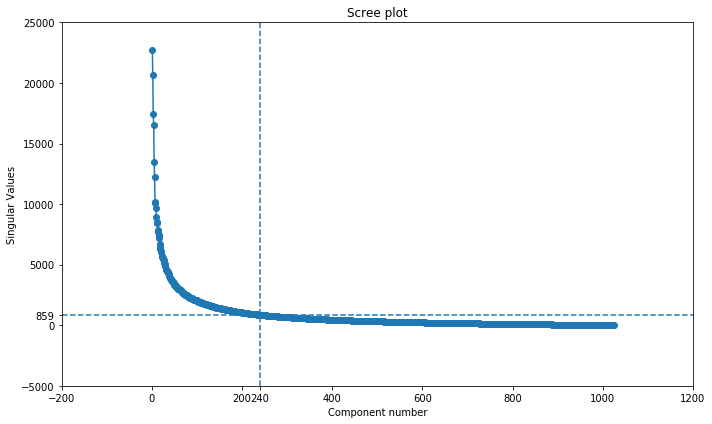

In [75]:
# Plotting a scree plot
x1 = range(1,s.shape[0]+1)
y1 = s
#Plot a line graph
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(x1, y1, marker='o')
ax1.axhline(y=s[240], xmin=0, xmax=images.shape[1], ls='--')
ax1.axvline(x=240, ymin=0, ymax=s[240], ls='--')
x_ticks = np.append(ax1.get_xticks(), 240)
y_ticks = np.append(ax1.get_yticks(), s[240])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_title("Scree plot")
ax1.set(xlabel="Component number",ylabel="Singular Values")
fig.tight_layout()
plt.show()

In [76]:
#dropping the unwanted columns in U matrix to form the feature matrix.
u = u[:,:240]

In [77]:
#Dot product of all the images and U matrix to find the projection co-efficients

dot_train = np.empty(shape = (u.shape[1], images.shape[1]),  dtype=np.int8) #360 by 360
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8) #1 by 360

# dot_train.shape : (120, 720)
# temp.shape : (1, 120)
# images.shape : (10000, 720)

for i in range(images.shape[1]):    # i from 0 to 360
    for c in range(u.shape[1]):    # c from 0 to 360
        temp[0,c] = np.sum(images[:,i] * u[:,c])
        
    dot_train[:, i] = temp[:]

In [78]:
# REPEAT THE EXECUTION OF CODE BELOW FOR NEW INPUT

In [79]:
#Path for the training images

Path = './test/'
tfiles = os.listdir(Path)
tfiles.sort()

In [80]:
test_images = []

for name in tfiles:
    temp = cv2.imread('./test/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (x_dim,y_dim), interpolation = cv2.INTER_AREA)
    test_images.append(temp.flatten())

In [81]:
#Substracting mean
test_images = np.array(test_images)
test_images = test_images - image_mean
test_images = test_images.T

In [82]:
#Dot product of test image and U matrix

dot_test = np.empty(shape = (u.shape[1], test_images.shape[1]), dtype=np.int8)
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8)
    
for i in range(test_images.shape[1]):    # i from 0 to 432
    for c in range(u.shape[1]):    # c from 0 to 240
        temp[0,c] = np.sum(test_images[:,i] * u[:,c])
    dot_test[:, i] = temp[:]

In [83]:
# calculating the variation between input image and test images
answer = np.empty(shape=(dot_train.shape[1],dot_test.shape[1]))
for i in range(dot_test.shape[1]):
    sub = np.empty(shape = (u.shape[1], dot_train.shape[1]), dtype=np.int8)
    for col in range(dot_train.shape[1]):
        sub[:,col] = dot_train[:,col] - dot_test[:,i]
    for c in range(sub.shape[1]):    
        answer[c,i] = np.linalg.norm(sub[:,c])

In [84]:
def min_index(temp):
    m = 0
    for i in range(len(temp)):
        if temp[i]<temp[m]:
            m = i
    return m

# Kavya : using sort() function would be more efficient.

In [85]:
# FACE RECOGNITION
temp_ans = np.empty(shape=(answer.shape[1],),dtype=int)
temp = np.empty(shape=(answer.shape[0],))
for i in range(0,answer.shape[1]):
    temp = answer[:,i]
    temp_ans[i] = min_index(temp)

In [86]:
unmatched = []
right = 0
total = test_images.shape[1]
for i in range(temp_ans.shape[0]):
    if tfiles[i].split(".")[0] == files[temp_ans[i]].split(".")[0]:
        right+=1
    else:
        unmatched.append(" ".join((tfiles[i].split(".")[0],files[temp_ans[i]].split(".")[0],str(temp_ans[i]))))
acc = (right/total)*100
print("Accuracy: ",acc,"%\n")
print("Face that matched incorrectly:\n")
for i in unmatched:
    print(i)

Accuracy:  94.37086092715232 %

Face that matched incorrectly:

9540636 mroper 1439
9540644 gllong 913
9540687 rhosan 1785
9540695 djevan 695
9540768 agaffa 395
amtalb sdaly 1885
arwebb jphoor 1209
arwebb mroper 1448
cpatki pjburr 1636
darodr pjburr 1634
dhaydo acatsa 373
djevan jjkeho 1145
djotto 9540725 208
djpben pjburr 1645
djpben gjbods 899
dlwise jjdacl 1136
filip57707 kdaska 1232
gdsamp mkvwon 1409
gdsamp rposbo 1826
gllong wardcy 2069
gmagul fmquaz 825
hwyman fmquaz 834
hwyman acatsa 369
ischou amflem 433
ischou 9540504 18
ischou 9540814 284
jepott shpill 1915
jjdacl 9540822 295
jjdacl mystery 1481
jjkeho kdaska 1232
kdaska jjkeho 1149
ldebna jlrums 1185
ldebna snhopp 1977
mamago pguan 1632
mwillc kdaska 1239
mystery pjburr 1647
nhahme amtalb 457
nhahme cpatki 602
nmakri 9540733 222
pgfost memiah 1354
pgfost memiah 1354
pjburr mystery 1492
reaton dmcdow 766
rshaw ischou 1057
sdaly pjburr 1641
smredh mystery 1484
smredh mystery 1487
tjpret 9540725 195
tthurs elalio 805
wardcy cp

In [87]:
#Saving sample test cases and their outputs.
position = (9,9) # position of the text on the image (25,30) incase of 100 by 100
count = 0
h = []
v = []
for i in random.sample(range(test_images.shape[1]),4): #we sample 4 random images from the images matrix
    reshape = np.reshape(test_images[:,i], (32, 32)) #input face
    oreshape = np.reshape(images[:,temp_ans[i]], (32, 32)) #output face
    new_p = Image.fromarray(reshape) #reshaping the input face
    new_p = new_p.convert("RGB") #convert to RGB image. It will be still grayscale, but this is done to add the colored text
    new_p = np.array(new_p) #making numpy array
    new_p= cv2.copyMakeBorder(new_p,3,3,5,2,cv2.BORDER_CONSTANT,value=[255,255,255]) #making a white border 10,10,15,5 incase of 100 by 100
    new_f = Image.fromarray(oreshape) #reshaping the output face
    new_f = new_f.convert("RGB") #convert to RGB image. It will be still grayscale, but this is done to add the colored text
    new_f = np.array(new_f)#making numpy array
    new_f= cv2.copyMakeBorder(new_f,3,3,2,5,cv2.BORDER_CONSTANT,value=[255,255,255])#making a white border 10,10,5,15 incase of 100 by 100
    #this is for adding the predicted name onto the output face
    cv2.putText(new_f, files[temp_ans[i]].split(".")[0], position, cv2.FONT_HERSHEY_SIMPLEX,0.16, (255, 255, 255), 1, cv2.LINE_AA) #0.5 instead of 0.16 incase of 100 by 100
    h.append(np.concatenate((new_p, new_f),axis = 1)) #appending the 4 input-output images to a list

def type1(a,b,c,d):
    g = np.concatenate((a,b),axis = 1) #concatenating two images horizontally.
    i = np.concatenate((c,d),axis = 1) #concatenating two images horizontally.
    cv2.imwrite("Sample.jpg",np.concatenate((g,i),axis = 0)) #concatenating two images vertically and saving it.

type1(*h)